In [1]:
import face_recognition
import os
import pandas as pd
import numpy as np
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from scikit_checkpoint import ScikitCheckpoint
from sklearn.cluster import KMeans
from PIL import Image
import pickle
import json
%matplotlib inline
from matplotlib.pyplot import imshow
np.random.seed(4)

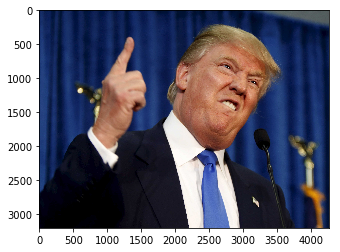

In [2]:
## Load original image

image_path = os.path.join(os.environ.get("DATA_DIR"), 'test','test_image.jpg')

image = face_recognition.load_image_file(image_path)
imgplot = imshow(image)

A face is located at pixel location Top: 430, Left: 2270, Bottom: 1810, Right: 3650


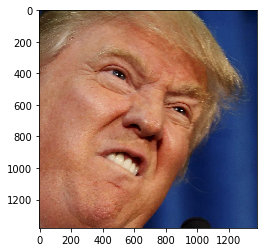

In [3]:
## Facial Detection
face_locations = face_recognition.face_locations(image)
len(face_locations)
for face_location in face_locations:
    # Print the location of each face in this image
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))
    # You can access the actual face itself like this:
    face_image = image[top:bottom, left:right]
    imgplot = imshow(face_image)


In [4]:
data = []
target = []
face_names = []
num_faces = len(face_names)
# Training load data
faces_selected = set()
class_names = ['donald_trump','putin','other']
for file_path in glob(os.environ.get("DATA_DIR")+"/*/*"):
    class_name = file_path.split('/')[-2]
    if class_name in class_names and class_name != 'test':
        if class_name not in faces_selected:
            faces_selected.add(class_name)
            face_names.append(class_name)
        load_image = face_recognition.load_image_file(file_path)
        list_encoding = face_recognition.face_encodings(load_image)
        if len(list_encoding) > 0:
            face_encoding = list_encoding[0]
            data.append(face_encoding)
            target.append(face_names.index(class_name))

In [5]:
print face_names
face_names = np.array(face_names)
data = np.asarray(data)
dimensions = range(len(face_encoding))

['other', 'donald_trump', 'putin']


In [6]:
df = pd.DataFrame(data, columns=dimensions)
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .60
df['face'] = pd.Categorical.from_codes(target, face_names)
df.head()

0         1         2         3         4         5         6  \
0 -0.099646  0.150337 -0.031157 -0.067576 -0.099756  0.044092 -0.003369   
1 -0.142703  0.055087  0.189977 -0.137793 -0.073138 -0.016489 -0.006097   
2 -0.163849  0.113063  0.044101 -0.036052 -0.040595 -0.009573 -0.040159   
3 -0.105577  0.053696 -0.049880 -0.062775 -0.070559 -0.026069  0.016290   
4 -0.143930  0.100308  0.046281 -0.057977  0.023746 -0.086313  0.015235   

          7         8         9  ...         120       121       122  \
0 -0.007982  0.147150 -0.025015  ...    0.031742  0.036646 -0.160967   
1 -0.144066  0.106089 -0.190353  ...   -0.082010  0.009533 -0.246792   
2 -0.059286  0.168056 -0.104745  ...    0.006919  0.040857 -0.121037   
3 -0.092182  0.175580 -0.096274  ...    0.029728 -0.002376 -0.148723   
4 -0.061996  0.169929 -0.000475  ...    0.011518  0.056770 -0.118005   

        123       124       125       126       127  is_train   face  
0 -0.126963  0.033340  0.011252 -0.018887  0.029731     False  other  
1 -0.108270  0.064536  0.018114 -0.005688  0.044132      True  other  
2 -0.068038 -0.002045 -0.020345  0.027445  0.019615     False  other  
3 -0.077927  0.028796  0.026030  0.085918  0.002564     False  other  
4 -0.050544 -0.017440  0.057096  0.028643  0.036724     False  other  

[5 rows x 130 columns]

In [7]:
train, test = df[df['is_train']==True], df[df['is_train']==False]

In [8]:
features = df.columns[:len(face_encoding)]
clf = RandomForestClassifier(n_jobs=6)
y, _ = pd.factorize(train['face'])
clf.fit(train[features], y)
preds = face_names[np.array(clf.predict(test[features]))]
cross_validation = pd.crosstab(test['face'], preds, rownames=['actual'], colnames=['preds'])
print(cross_validation)
stats = {'label': 'random_forest','cross_validation':str(cross_validation)}
model_filename = os.path.join(os.environ['SNAPSHOTS_DIR'], 'model.p')
stats_filename = os.path.join(os.environ['SNAPSHOTS_DIR'], 'stats.json')
pickle.dump(clf, open(model_filename, 'wb'))
with open(stats_filename, 'wb') as f:
            f.write(json.dumps(stats))

preds         donald_trump  other  putin
actual                                  
other                    1      7      0
donald_trump             4      1      0
putin                    0      1      5


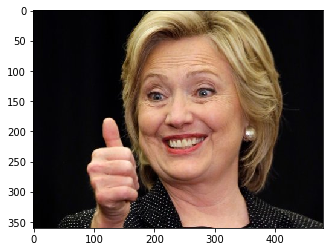

In [25]:
## Load test image

#image_path = os.path.join(os.environ.get("DATA_DIR"), 'test','test_image.jpg')
#image_path = os.path.join(os.environ.get("DATA_DIR"), 'test','test_image_putin.jpg')
image_path = os.path.join(os.environ.get("DATA_DIR"), 'test','test_image1.jpg')
load_image = face_recognition.load_image_file(image_path)
imgplot = imshow(load_image)

In [29]:
## Facial Recognition classifier
list_encoding = face_recognition.face_encodings(load_image)
test_pred = face_names[np.array(clf.predict(list_encoding))]
print test_pred

['other']


In [30]:
### Object detection 

import requests
import httplib
import urllib2
# Use api_key
api_key='MAzIpsavqXdoKliK08ggxv4tOA7gqnE4'

headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'Authorization': api_key
}

def image_analytics_by_acusense_api(image_url):
    data = {
        "image_url": [image_url]
    }
    response = requests.post('http://api.acusense.ai/api/v1' + "/image/analytics", json=data, headers=headers)

    if response.status_code == 200:
        json_response = response.json()
    else:
        json_response = {'result':{}}

    return json_response



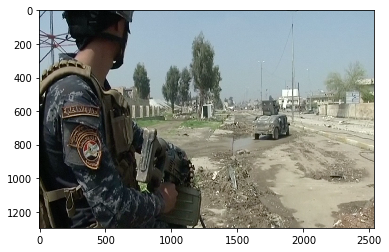

vehicle     calamity     transportation system     war     battle     industry     army     military     accident     soil     danger     track     road     environment     dust     machine     outdoors     truck     weapon     pollution     travel     car     police     soldier     landscape     mud     people     heavy


In [32]:
from IPython.display import display, Image
import matplotlib.pyplot as plt
# create a file-like object from the url
image_url = 'https://s3-us-west-1.amazonaws.com/acusense-training-sets/reuters/Images/Screen+Shot+2017-05-10+at+4.56.30+PM.png'
f = urllib2.urlopen(image_url)

# read the image file in a numpy array
a = plt.imread(f)
plt.imshow(a, aspect='auto')
plt.show()

api_response = image_analytics_by_acusense_api(image_url=image_url)
for response in api_response['result']['images']:
    print '     '.join(response['visual_tags'])

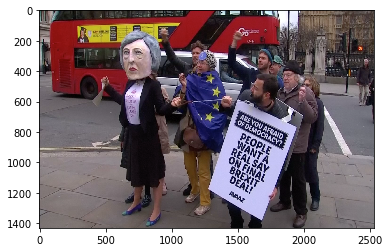

police   people   offense   street   rally   battle   road   picket   city   drag race   election   man   education   woman   vehicle   school   administration   military   law enforcement   adult   group   rebellion


In [33]:
image_url = 'https://s3-us-west-1.amazonaws.com/acusense-training-sets/reuters/Images/Screen+Shot+2017-05-10+at+5.04.03+PM.png'
f = urllib2.urlopen(image_url)

# read the image file in a numpy array
a = plt.imread(f)
plt.imshow(a, aspect='auto')
plt.show()

api_response = image_analytics_by_acusense_api(image_url=image_url)
for response in api_response['result']['images']:
    print '   '.join(response['visual_tags'])

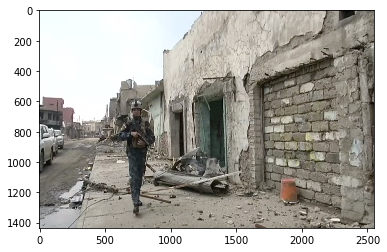

building  architecture  old  wall  city  stone  street  town  travel  religion  people  calamity  military  tourism  outdoors  house  ancient  urban  battle  adult  war  home  brick  road  daylight


In [34]:
image_url = 'https://s3-us-west-1.amazonaws.com/acusense-training-sets/reuters/Images/Screen+Shot+2017-05-10+at+4.57.12+PM.png'
f = urllib2.urlopen(image_url)

# read the image file in a numpy array
a = plt.imread(f)
plt.imshow(a, aspect='auto')
plt.show()

api_response = image_analytics_by_acusense_api(image_url=image_url)
for response in api_response['result']['images']:
    print '  '.join(response['visual_tags'])